In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import GridSearchCV
from alpha_common_functions import lineplot

from sklearn import set_config
set_config(display="diagram")

In [2]:
df = pd.read_csv("data/vehicles_v3.csv")

# Drop Columns
#### 1. title_status has least variance with almost 95% of them have 'clean' status. We will not be considering the feature in model fitting.
#### 2. 71% of records are missing size, we will thus be skipping them too.
#### 3. region has 404 distinct values, this we will only consider state for the prediction 

In [3]:
df.drop(columns=['title_status','size','region'], inplace=True)

# Train - Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['price'], axis=1), df['price'], test_size = 0.3, random_state = 42)

# Answer check
print(X_train.shape)
print(X_test.shape)

(211026, 11)
(90440, 11)


# Pre Processing

![](images/PreProcessing.svg)

## Transformers

### cylinders - OrdinalEncoder
1. Similarly 15.61% od NaN will be lables as "other" and will combine with	0.24% of "other"
2. We will have total 7 unique categories
   Categories: [0.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0, 12.0]
   unknown_category = 9
   missing_category = -1

In [5]:
categories_ = [[0.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0, 12.0]]
unknown_categories_ = len(categories_[0])
missing_categories_ = -1

cylinders_ordinal_encoder = OrdinalEncoder(encoded_missing_value=missing_categories_, categories=categories_, unknown_value=unknown_categories_, handle_unknown='use_encoded_value')                                           

### condition - OrdinalEncoder
1. 35.44% of records have no condition provided. we will be putting all of them to new label "other"
2. We will have total 7 unique categories
   Categories: ["salvage", "fair", "good", "excellent","like new", "new"]
   unknown_category = 6
   missing_category = -1


In [6]:
categories_=[["salvage", "fair", "good", "excellent","like new", "new"]]
condition_ordinal_encoder = OrdinalEncoder(encoded_missing_value=-1, categories=categories_, unknown_value=6, handle_unknown='use_encoded_value')                                           

### transmission - (SimpleImputer -> OneHotEncoder)
1. Only 0.33% of all records are null. We do have additional category of "other" which is 18%+. Thus we will add 0.33%  of null as "other"
2. This will narrow down the transmossion to just 3 subcategories
### fuel - (SimpleImputer -> OneHotEncoder)
1. 0.07% of nissing values will be combined with 7.88% of "others"
2. We will have total 5 unique categories
### type - (SimpleImputer -> OneHotEncoder)
1. 15.21 of NaN will be combined with 5.37% of Other
2. In Total 12 categories will be remaining
### drive - (SimpleImputer -> OneHotEncoder)
1. 26.31% of NaN will be renamed as "Others
2. Total remaining categories will be 4
### paint_color - (SimpleImputer -> OneHotEncoder)
1. 28.19% of NaN will be renamed as "Others
2. Total remaining categories will be 13

In [7]:
simple_imputer = SimpleImputer(strategy='constant', fill_value='other')

<div class="alert alert-block alert-success">
    <font size=6 color='black'>
        Model 9
    </font>
    <br>
    <font size=5 color='black'>
    <u>SequentialFeatureSelector</u>
    </font>
    <br>
    <font size=4 color='black'>
        1. ColumnTransformation<br>
        - OrdinalEncoder > PolynomialFeature (degree=2) on 'cylinders' and 'condition' on separate pipelines<br> 
        - SimpleImputer > OneHotEncoder on 'transmission','fuel', 'type', 'drive', 'paint_color' in a pipeline<br>
        - StandardScaler > PolynomialFeatures (degree=2) on ['year', 'odometer']<br>           
        2. Ridge (default alpha=1)<br>    
    </font>
    </p>
</div>

In [8]:
transformer = make_column_transformer(
    (Pipeline([
        ('simple_imputer', simple_imputer),
        ('one_hot_encoder', OneHotEncoder())
    ]),['transmission','fuel', 'type', 'drive', 'paint_color']),
    (OneHotEncoder(),['manufacturer','state']),
    (Pipeline([
        ('ordinal',cylinders_ordinal_encoder), 
        ('poly', PolynomialFeatures(include_bias = False, degree = 2))]), ['cylinders']),     
    (Pipeline([
        ('ordinal',condition_ordinal_encoder), 
        ('poly', PolynomialFeatures(include_bias = False, degree = 2))]), ['condition']),     
    (Pipeline([
        ('scalar', StandardScaler()),
        ('poly', PolynomialFeatures(include_bias = False, degree = 2))
    ]) , ['year', 'odometer']),
    remainder='passthrough')

In [9]:
pipeline = Pipeline([('transformer', transformer),  
                     ('rigid', Ridge())])

In [10]:
pipeline.fit(X_train[['year', 'odometer','condition','cylinders', 'manufacturer','state', 'transmission','fuel', 'type','drive', 'paint_color']], y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value='other',
                                                                                 strategy='constant')),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder())]),
                                                  ['transmission', 'fuel',
                                                   'type', 'drive',
                                                   'paint_color']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['manufacturer', 'state']),
                                                 ('pipelin...
                                                                   OrdinalEncoder(categories=[['salvage',
                                                                                               'fair',
                                                                                               'good',
                                                                                               'excellent',
                                                                                               'like '
                                                                                               'new',
                                                                                               'new']],
                                                                                  encoded_missing_value=-1,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=6)),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['condition']),
                                                 ('pipeline-4',
                                                  Pipeline(steps=[('scalar',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['year', 'odometer'])])),
                ('rigid', Ridge())])

In [11]:
y_train_predict = pipeline.predict(X_train[['year', 'odometer','condition','cylinders', 'manufacturer','state', 'transmission','fuel', 'type','drive', 'paint_color']])
y_test_predict = pipeline.predict(X_test[['year', 'odometer','condition','cylinders', 'manufacturer','state', 'transmission','fuel', 'type','drive', 'paint_color']])
#predict on train and test
train_mses=(mean_squared_error(y_train, y_train_predict))
test_mses=(mean_squared_error(y_test, y_test_predict))

In [12]:
print(train_mses)
print(test_mses)

35454726.4658569
35324613.363171615


In [13]:
pipeline.named_steps['rigid'].get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.0001}

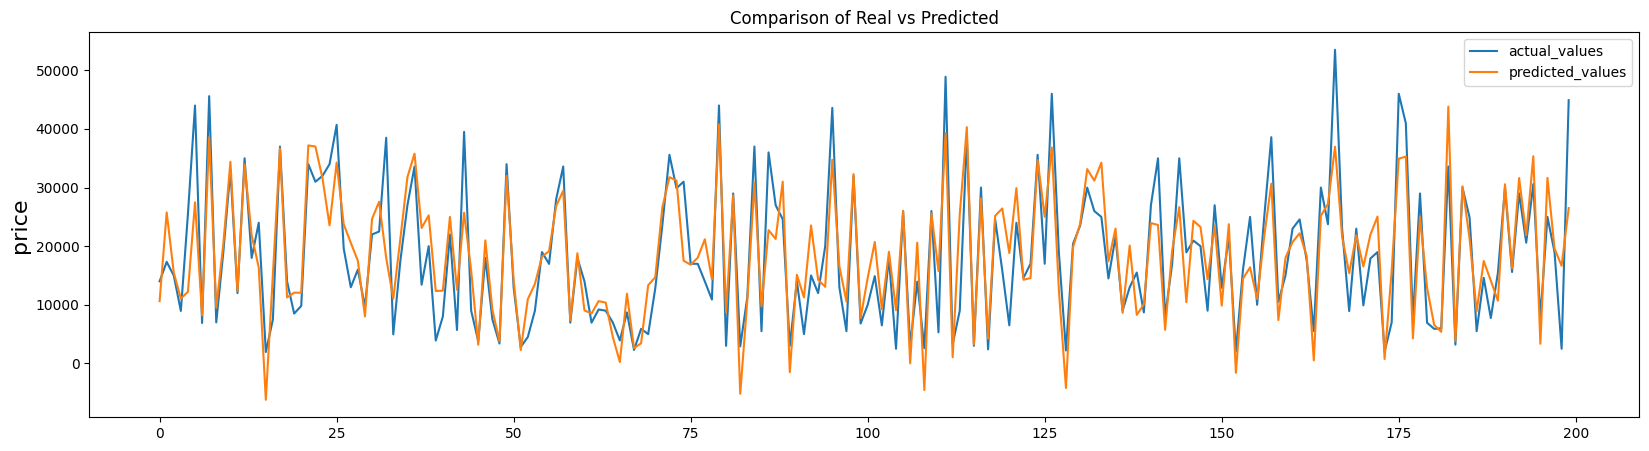

In [14]:
lineplot(y_test, y_test_predict, 200, "Ridge_alpha_1")

<div class="alert alert-block alert-info">
    <font size=4 color='black'>
        Determine the optimum value of alpha
    </font>
</div>

In [15]:
pipeline = Pipeline([('transformer', transformer),  ('ridge', Ridge())])

In [16]:
param_dict = {'ridge__alpha': [0.001, 0.1, 1.0, 10.0, 100.0, 1000.0]}
grid_2 = GridSearchCV(pipeline, param_grid=param_dict, cv=5, scoring='neg_mean_squared_error')

In [17]:
grid_2.fit(X_train[['year', 'odometer','condition','cylinders', 'manufacturer','state', 'transmission','fuel', 'type','drive', 'paint_color']], y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simple_imputer',
                                                                                          SimpleImputer(fill_value='other',
                                                                                                        strategy='constant')),
                                                                                         ('one_hot_encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['transmission',
                                                                          'fuel',
                                                                          'type',
                                                                          'drive',
                                                                          'paint_color']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['manuf...
                                                                                                         handle_unknown='use_encoded_value',
                                                                                                         unknown_value=6)),
                                                                                         ('poly',
                                                                                          PolynomialFeatures(include_bias=False))]),
                                                                         ['condition']),
                                                                        ('pipeline-4',
                                                                         Pipeline(steps=[('scalar',
                                                                                          StandardScaler()),
                                                                                         ('poly',
                                                                                          PolynomialFeatures(include_bias=False))]),
                                                                         ['year',
                                                                          'odometer'])])),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': [0.001, 0.1, 1.0, 10.0, 100.0,
                                          1000.0]},
             scoring='neg_mean_squared_error')

In [18]:
model_2_best_alpha = grid_2.best_params_
model_2_best_alpha

{'ridge__alpha': 10.0}

<div class="alert alert-block alert-success">
    <font size=6 color='black'>
        Model 10
    </font>
    <br>
    <font size=5 color='black'>
    <u>SequentialFeatureSelector</u>
    </font>
    <br>
    <font size=4 color='black'>
        1. ColumnTransformation<br>
        - OrdinalEncoder > PolynomialFeature (degree=2) on 'cylinders' and 'condition' on separate pipelines<br> 
        - SimpleImputer > OneHotEncoder on 'transmission','fuel', 'type', 'drive', 'paint_color' in a pipeline<br>
        - StandardScaler > PolynomialFeatures (degree=2) on ['year', 'odometer']<br>           
        2. Ridge (alpha=10)<br>    
    </font>
    </p>
</div>

In [19]:
pipeline = Pipeline([('transformer', transformer),  ('ridge', Ridge(alpha=10))])

In [20]:
pipeline.fit(X_train[['year', 'odometer','condition','cylinders', 'manufacturer','state', 'transmission','fuel', 'type','drive', 'paint_color']], y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value='other',
                                                                                 strategy='constant')),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder())]),
                                                  ['transmission', 'fuel',
                                                   'type', 'drive',
                                                   'paint_color']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['manufacturer', 'state']),
                                                 ('pipelin...
                                                                   OrdinalEncoder(categories=[['salvage',
                                                                                               'fair',
                                                                                               'good',
                                                                                               'excellent',
                                                                                               'like '
                                                                                               'new',
                                                                                               'new']],
                                                                                  encoded_missing_value=-1,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=6)),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['condition']),
                                                 ('pipeline-4',
                                                  Pipeline(steps=[('scalar',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['year', 'odometer'])])),
                ('ridge', Ridge(alpha=10))])

In [21]:
y_train_predict = pipeline.predict(X_train[['year', 'odometer','condition','cylinders', 'manufacturer','state', 'transmission','fuel', 'type','drive', 'paint_color']])
y_test_predict = pipeline.predict(X_test[['year', 'odometer','condition','cylinders', 'manufacturer','state', 'transmission','fuel', 'type','drive', 'paint_color']])
#predict on train and test
train_mses=(mean_squared_error(y_train, y_train_predict))
test_mses=(mean_squared_error(y_test, y_test_predict))

In [22]:
print(train_mses)
print(test_mses)

35462355.35987914
35329028.7862134


In [23]:
pipeline.named_steps['ridge'].get_params()

{'alpha': 10,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.0001}

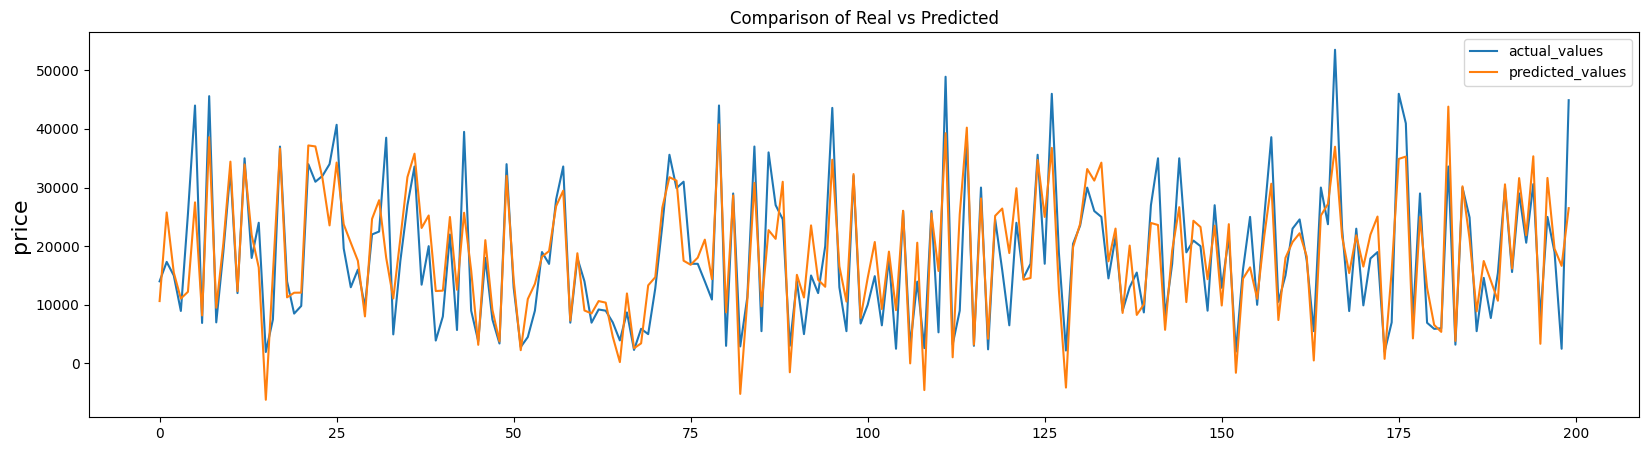

In [24]:
lineplot(y_test, y_test_predict, 200, "Ridge_ap=lpha_10")

In [25]:
all_features_names = pipeline.named_steps['transformer'].get_feature_names_out()
len(all_features_names)

139

In [28]:
pipeline.named_steps['ridge'].coef_

array([-1.09524062e+03,  7.06180641e+02,  3.89059997e+02,  9.18748804e+03,
       -4.07763341e+03, -2.31492053e+03, -2.11248701e+03, -6.82447084e+02,
       -8.32459958e+02, -5.55046718e+03,  2.28706665e+03,  1.68677705e+03,
       -2.48308569e+03, -7.86538236e+02,  2.03375696e+03,  6.25866420e+02,
        2.77752483e+03, -1.80571029e+03,  3.63832118e+03, -2.76341145e+02,
       -1.31471059e+03,  2.12556297e+03, -1.91775087e+03, -7.04654715e+02,
        4.96842620e+02,  3.73472825e+02, -2.60034085e+02, -2.31910050e+02,
        7.60258037e+01,  4.15562337e+02, -5.57832939e+02, -5.68048524e+02,
       -2.06063005e+02,  3.43943993e+02,  1.22243453e+02, -4.37998032e+02,
        1.99333450e+02,  7.31304770e+02,  2.40072424e+02,  3.85751146e+03,
        2.57521391e+03,  3.46526359e+03,  1.21344767e+03, -2.06637204e+03,
        1.36982344e+03, -5.47398054e+02, -3.42237772e+03, -2.83168216e+03,
       -1.70102565e+03, -6.46423572e+03, -9.31291543e+02,  7.67519532e+02,
       -5.57613560e+03, -